# 분류 순위 평가
- 컨퓨전 매트릭스 기반으로 한 분류의 기본적인 성능평가 (정적인 평가)
 - 정확도, 정밀도, 리콜, f-1 점수 등
- 분류 모델의 종합적인 성능 평가를 하기 위해서는 순위(랭킹)을 평가해야 한다
 - 이를 위해서 ROC-AUC, precision-recall curve, mAP 등을 사용한다
 - 최적의 분류 경계값(기준값: threshold) 또는 확률 기준의 설정이 필요하다

## import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.metrics import precision_recall_curve, average_precision_score

# 10명의 환자 검진 예

In [3]:
np.random.seed(19)
raw_scores = np.random.randint(30,99,10)

df = pd.DataFrame({"점수":raw_scores})
df = df.sort_values(['점수'], ascending=False)

threshold =  65
pred_cancer = df["점수"] > threshold

df["진단"] = pred_cancer.astype(int)
df['실제암발생'] = np.array([1,1,0,1,0,1,1,0,0,0])
df

,점수,진단,실제암발생
4,96,1,1
5,86,1,1
2,82,1,0
0,70,1,1
7,64,0,0
3,61,0,1
6,52,0,1
1,49,0,0
9,40,0,0
8,35,0,0


## 컨퓨전 매트릭스와 정적 성능 평가
- 상위 4명을 암으로 진단한 경우
- 여기서는 편의상 점수순으로 소팅된 데이터를 사용한다

In [4]:
def show_clf_result(y_test, y_pred):
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
def get_prec_recall_sorted(y_test, y_pred):
    return precision_score(y_test, y_pred), recall_score(y_test, y_pred)

In [5]:
y_pred = df['진단']
y_test = df['실제암발생']

show_clf_result(y_test, y_pred)

[[4 1]
 [2 3]]
              precision    recall  f1-score   support

           0       0.67      0.80      0.73         5
           1       0.75      0.60      0.67         5

    accuracy                           0.70        10
   macro avg       0.71      0.70      0.70        10
weighted avg       0.71      0.70      0.70        10



In [6]:
get_prec_recall_sorted(y_test, y_pred)

(0.75, 0.6)

## 다른 분류 경계치(threshold)를 선택한 경우
- 분류 경계치 65점을 변경하여 상위 1, 2, 3,.., 7 명을 각각 암 환자라고 진단한 경우 정적 성능 지표가 달라진다

In [7]:
list_y_pred = [[1,0,0,0,0,0,0,0,0,0],
    [1,1,0,0,0,0,0,0,0,0],
    [1,1,1,0,0,0,0,0,0,0],
    [1,1,1,1,0,0,0,0,0,0],
    [1,1,1,1,1,0,0,0,0,0],
    [1,1,1,1,1,1,0,0,0,0],
    [1,1,1,1,1,1,1,0,0,0]]

for y_pred in list_y_pred:
    p,r = get_prec_recall_sorted(y_test, y_pred)
    print('precision=',p.round(2), 'recall',r)

precision= 1.0 recall 0.2
precision= 1.0 recall 0.4
precision= 0.67 recall 0.4
precision= 0.75 recall 0.6
precision= 0.6 recall 0.6
precision= 0.67 recall 0.8
precision= 0.71 recall 1.0


- 검토
 - 분류 결정 경계치(threshold)를 다른 값으로 택하면 정확도, 정밀도, 리콜 등의 기본 성능 척도가 달라진다
 - 즉, 모델의 실제적인 분류 능력에는 변함 없으면서, 성능을 다른 값으로 선택할 수 있다
 - 분류 경계치를 낮게 정할수록 리콜은 증가하지만, 정밀도는 나빠진다. 반대로 분류 경계치를 높게 정할수록 정밀도는 증가하지만 리콜은 나빠진다

# 분류 순위(랭킹) 평가 방법
## ROC 커브

- 경계치를 한 샘플씩 낮추면서 positive 예측이 맞는지, 틀리는지를 2차원 평면에 그린 것을 ROC(Response of Characteristic) 커브라고 한다

- (0,0) 점에서 시작하여, 점수순으로 소팅한 테이블의 y_test 값을 하나씩 따라 내려오면서 positive를 맞추면 위로, 틀리면 우로 한 칸씩 이동하여 최종 (1,1) 지점에 도착한다
 - TRP: True Positive Rate
 - FPR: False Positive Rate
- 위로 올라갈 횟수는 전체 샘플수중에 positive 샘플수이고, 우로 이동할 횟수는 negative 샘플수이다
 
<img src="https://raw.githubusercontent.com/data-labs/image/main/%E1%84%89%E1%85%B3%E1%84%8F%E1%85%B3%E1%84%85%E1%85%B5%E1%86%AB%E1%84%89%E1%85%A3%E1%86%BA%202021-01-03%20%E1%84%8B%E1%85%A9%E1%84%92%E1%85%AE%209.15.05.png?raw=1" width=330 align='left'>

- 정확도, 정밀도, 리콜 등은 분류 경계치를 얼마로 정하는가에 따라서 수시로 달라질 수 있는 값이다. 즉 선택의 문제이다
- 이와 달리 ROC나 AUC는 분류 모델의 점수를 고려한, 즉 순서를 고려한 전체적인 성능 평가 방법이다.

###  AUC
- ROC 평가 결과를 간단히 하나의 숫자로 표현하기 위해서 ROC 커브의 면적을 사용한다
- 이를 AUC (Area Under Curve)라고 하며 0~1 사이의 값을 갖는다

- 랭킹 평가를 하려면 점수가 필요하다
 - 분류 예측에서 순위를 평가하려면 (즉, 예측치를 소팅하려면) 분류 결과가 특정 클래스에 속할 가능성을 나타내는 점수 또는 확률값이 필요하다
 - 선형 계열 분류 모델은 분류 점수를 제공하고 결정 트리, 로지스틱 회귀, 신경망 계열 모델은 분류 확률을 제공한다 (이 때 확률 값을 점수로 사용하면 된다)

### 10명 환자 분류의 ROC 커브
- 환자 10명을 점수순으로 소팅한 결과와 실제 암환자 사실 정보 (y_test)를 이용하여 ROC 커브를 그린다
- roc_curve 함수를 사용한다

In [8]:
df

,점수,진단,실제암발생
4,96,1,1
5,86,1,1
2,82,1,0
0,70,1,1
7,64,0,0
3,61,0,1
6,52,0,1
1,49,0,0
9,40,0,0
8,35,0,0


In [9]:
# 10명 환자의 암환자일 점수 (인덱스 번호로 환자를 구분한다)
scores_10 = df['점수']
scores_10

4    96
5    86
2    82
0    70
7    64
3    61
6    52
1    49
9    40
8    35
Name: 점수, dtype: int64

### ROC 커브 그리기

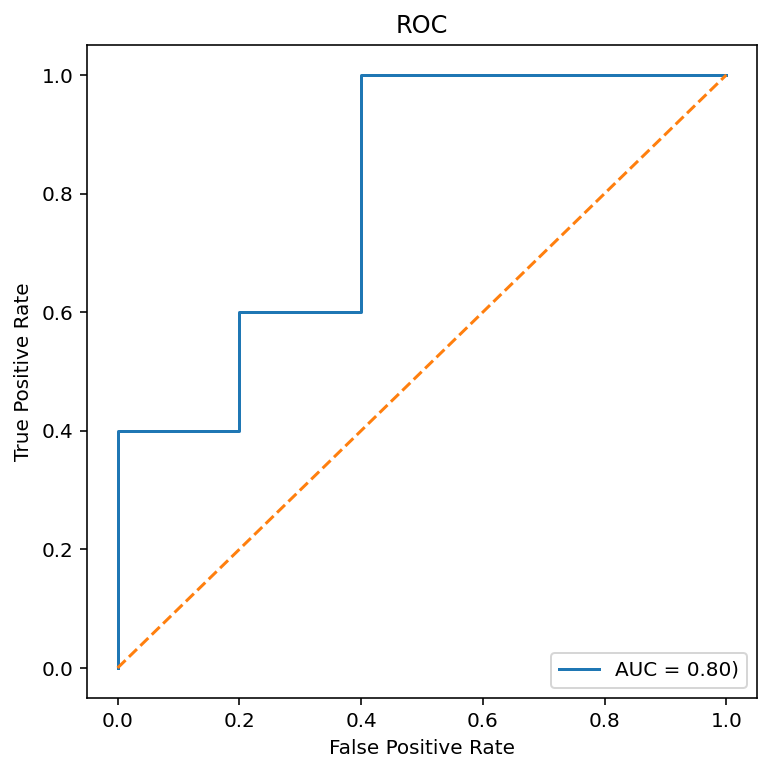

In [10]:
# ROC 커브를 그리기 위해서 roc_curve 함수를 사용한다
fpr, tpr, _ = roc_curve(y_test, scores_10)

# AUC 계산하기
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label='AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")

- ROC 커브는 예측 점수순으로 소팅한 y_test 값, [1,1,0,1,0,1,1,0,0,0]의 1,0,1,.. 순서만 알면 그릴 수 있다

## (연습) 점수순을 소팅한 결과 실제 값이 다음과 같을 때 ROC 를 그리시오
- 실제 값: [1,0,1,1,0,1,0,1,0,0]

In [11]:
# (풀이)



### ROC 성능 비교 예

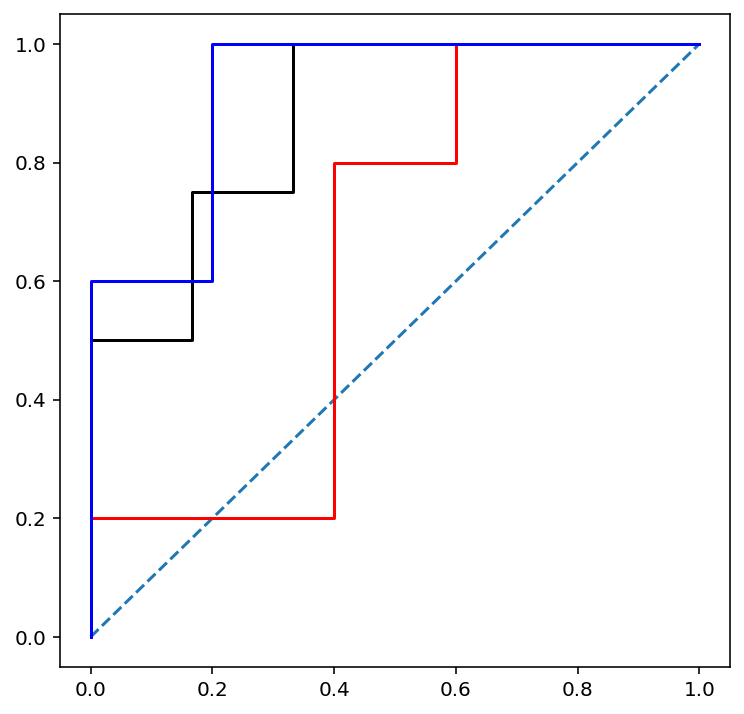

In [12]:
# 3명의 의사 실력을 비교
# 3명의 의사가 진단한 점수순으로 소팅했을 때 각각 실제 암환자를 찾아낸 순서가 아래와 같은 경우를 비교
# y_test의 앞쪽에서 (초반에) 암환자를 찾을수록 훌륭한 의사임

y_test_sample = [[1,0,0,1,1,1,0,1,0,0],
         [1,1,0,1,0,1,0,0,0,0],
         [1,1,1,0,1,1,0,0,0,0]]

plt.figure(figsize=(6,6))    
plt.plot([0, 1], [0, 1], linestyle='--')

my_color = ['r', 'k', 'b']
for i in range(len(y_test_sample)):
    fpr, tpr, _ = roc_curve(y_test_sample[i], scores_10)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, c=my_color[i])

## (연습) 위의 3명중 의사를 완벽한 의사와, 랜덤 예측 이하의 의사를 만들어 보시오

In [13]:
# (풀이)



## Precision-Recall 곡선
- 분류 경계치(threshold)를 하나씩 내려면서 리콜과 정밀도를 2차원 평면에 그리는 것

In [14]:
y_test = df['실제암발생']

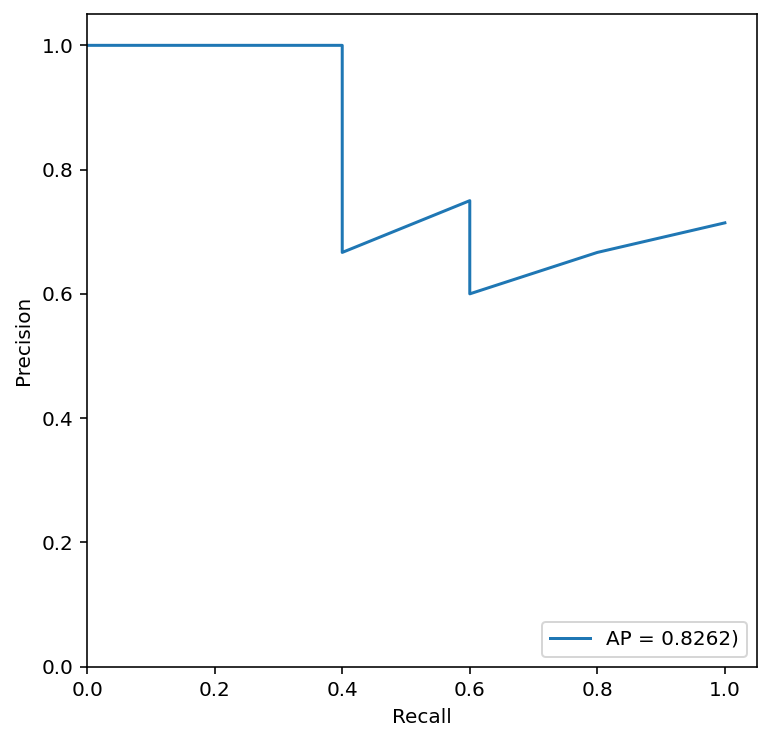

In [15]:
prec, rcl, thres = precision_recall_curve(y_test, scores_10)
ap = average_precision_score(y_test, scores_10)
plt.figure(figsize=(6,6))
plt.plot(rcl, prec, label='AP = %0.4f)' % ap)
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc="lower right")

In [16]:
# Precision-Recall 테이블 
PR = pd.DataFrame({"precision":prec[::-1], "recall":rcl[::-1]}).round(2)
PR

,precision,recall
0,1.00,0.0
1,1.00,0.2
2,1.00,0.4
3,0.67,0.4
4,0.75,0.6
5,0.60,0.6
6,0.67,0.8
7,0.71,1.0


<AxesSubplot:>

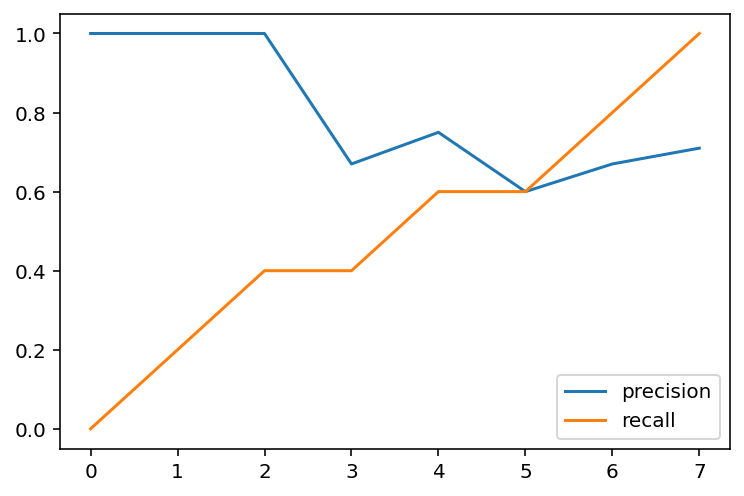

In [17]:
PR.plot()

### P-R 커브의 용도
- ROC-AUC는 분류의 성능을 종합적으로 평가하는데 사용되고
- P-R 커브는 원하는 최소한의 정밀도 또는 리콜 값을 만족하는 분류기를 찾을 때 사용한다
- 문제마다 정밀도가 높아야 하는 경우와 리콜이 높아야 하는 경우가 있다
 - (예) 스팸 메일을 찾아서 스팸함으로 보내는 분류기는 정밀도가 높아야 한다
 - 암을 찾는 작업은 리콜이 높아야 한다
- 동시에 정밀도와 리콜을 높이는 것이 어려우므로 (완벽한 모델이 아니면) 정밀도와 리콜 중 하나의 조건을 우선 만족하면서 다른 값이 가능한 높은 모델을 채택해야 한다
 - 이러한 조건을 만족하는 적절한 분류 경계치를 선택해야 하는 일이 많다
 
- 일반적으로 Precision의 평균치 (mAP: mean Average Precision) 값이 클수록 전체적으로 성능이 좋은 모델이다

# 참고: 최적의 분류 경계치 찾기

- 남여 성별 분류 문제에서 P-R 커브를 사용하여 정밀도 또는 리콜의 특정 조건을 만족하는 최적의 threshold 값을 찾는 방법을 소개한다

## 남여 성별 분류 문제

In [18]:
data = pd.read_csv("https://github.com/data-labs/data/raw/main/weight-height.csv")

# 성별 인코딩 (남:0, 여:1)
data.Gender = data.Gender.map({'Male':0, 'Female':1})
# 단위 변환 (인치, 파운드 --> cm, kg)
data.Height = data.Height*2.54 # cm
data.Weight = data.Weight*0.453592 # kg

- 성별  예측
 - X: 키와 몸무게 (2개의 특성 사용)
 - y: 성별 (이진 분류 문제)

In [19]:
X = data[["Height", "Weight"]]
y = data.Gender
X_sc = X.copy()
scaler = StandardScaler()
X_sc.loc[:,:] = scaler.fit_transform(X_sc)

X_train, X_test, y_train, y_test = train_test_split(X_sc, y)

model = SGDClassifier() # (1) 모델 생성
model.fit(X_train, y_train) # (2) 훈련
model.score(X_test, y_test) # (3) 평가 (정확도)

0.9184

- 기본 모델

In [20]:
# 성별 예측치
y_pred = model.predict(X_test)
show_clf_result(y_test, y_pred)

[[1175   83]
 [ 121 1121]]
              precision    recall  f1-score   support

           0       0.91      0.93      0.92      1258
           1       0.93      0.90      0.92      1242

    accuracy                           0.92      2500
   macro avg       0.92      0.92      0.92      2500
weighted avg       0.92      0.92      0.92      2500



## ROC-AUC
- 먼저 분류 점수 또는 확률을 얻은 후에 ROC 커브를 그린다

In [21]:
# 선형 분류 모델에서 의사결정에 사용한 "점수"를 얻는 함수: decision_function()
scores = model.decision_function(X_test)

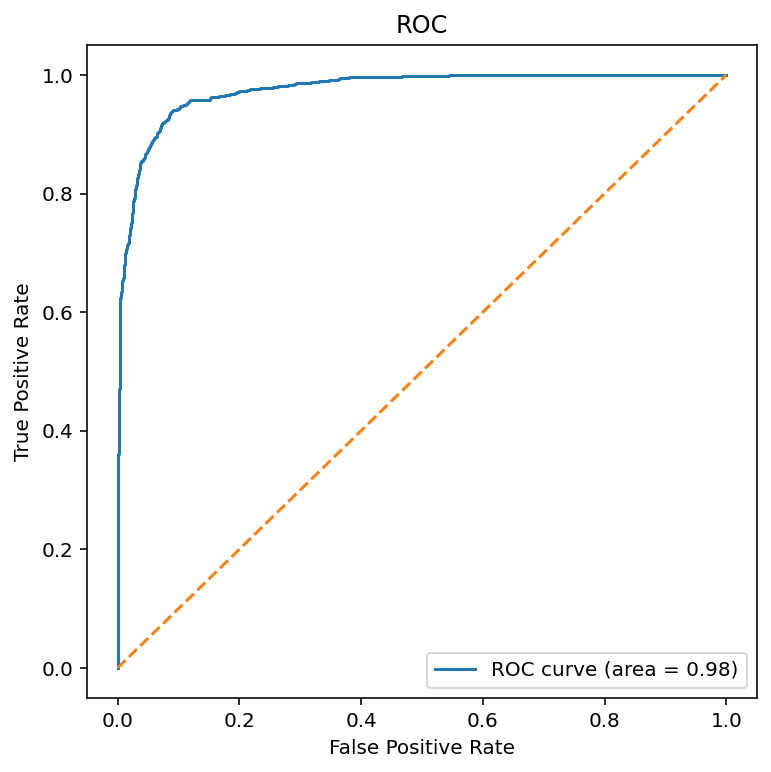

In [22]:
fpr, tpr, _ = roc_curve(y_test, scores)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")

In [23]:
# 점수순으로 소팅한 테이블 Z 만들기
df_rank = pd.DataFrame({"y_pred":y_pred, 
                  "y_test":y_test, "scores":scores}) 
df_rank = df_rank.sort_values(by=['scores'], ascending=False)
df_rank

,y_pred,y_test,scores
8241,1,1,7.944164
5026,1,1,7.122804
5191,1,1,6.996672
7215,1,1,6.816370
8620,1,1,6.770477
...,...,...,...
1154,0,0,-8.289727
3918,0,0,-8.326988
3090,0,0,-8.690633
3285,0,0,-9.179082


In [24]:
# 점수의 최소치를 0으로 최대치를 1로 스케일링한 컬럼 추가 (그래프를 보기 좋게)
from sklearn.preprocessing import MinMaxScaler
minmax = MinMaxScaler()
df_rank["scores_sc"] = minmax.fit_transform(df_rank.scores.values.reshape(-1,1))
df_rank

,y_pred,y_test,scores,scores_sc
8241,1,1,7.944164,1.000000
5026,1,1,7.122804,0.952652
5191,1,1,6.996672,0.945381
7215,1,1,6.816370,0.934987
8620,1,1,6.770477,0.932341
...,...,...,...,...
1154,0,0,-8.289727,0.064177
3918,0,0,-8.326988,0.062029
3090,0,0,-8.690633,0.041066
3285,0,0,-9.179082,0.012909


## 예측값, 실제값, 분류 경계치(threshold) 보기

- 예측값: 파란 선
- 실제값: 붉은 점
- 분류 경계치: 검정색 

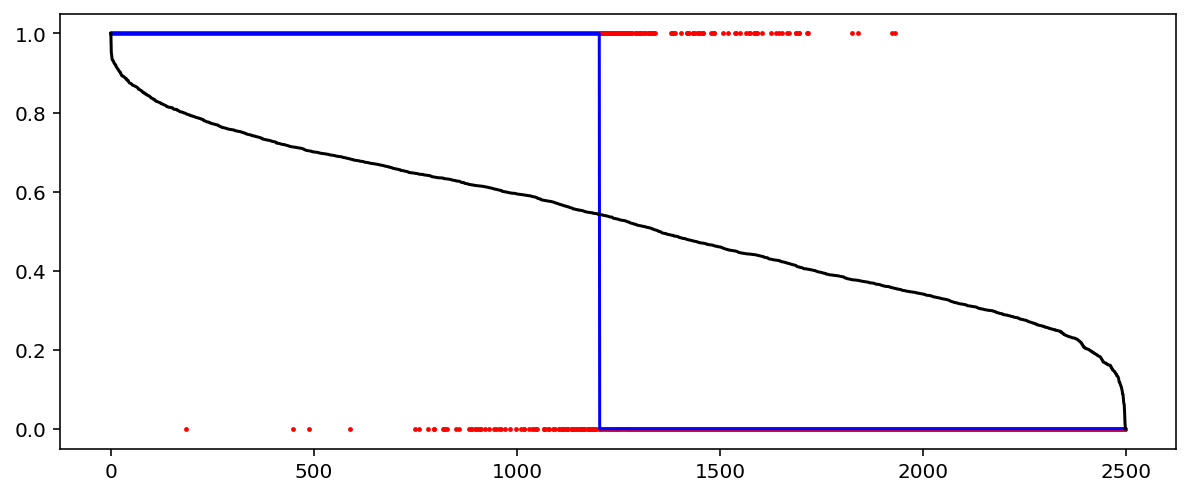

In [25]:
plt.figure(figsize=(10,4))
plt.scatter(range(len(y_test)), df_rank.y_test.values, c='r', s=2)
plt.plot(df_rank.y_pred.values, c='b')
plt.plot(df_rank.scores_sc.values, c='k')

In [26]:
show_clf_result(y_test, y_pred)

[[1175   83]
 [ 121 1121]]
              precision    recall  f1-score   support

           0       0.91      0.93      0.92      1258
           1       0.93      0.90      0.92      1242

    accuracy                           0.92      2500
   macro avg       0.92      0.92      0.92      2500
weighted avg       0.92      0.92      0.92      2500



## Precision-Recall 커브

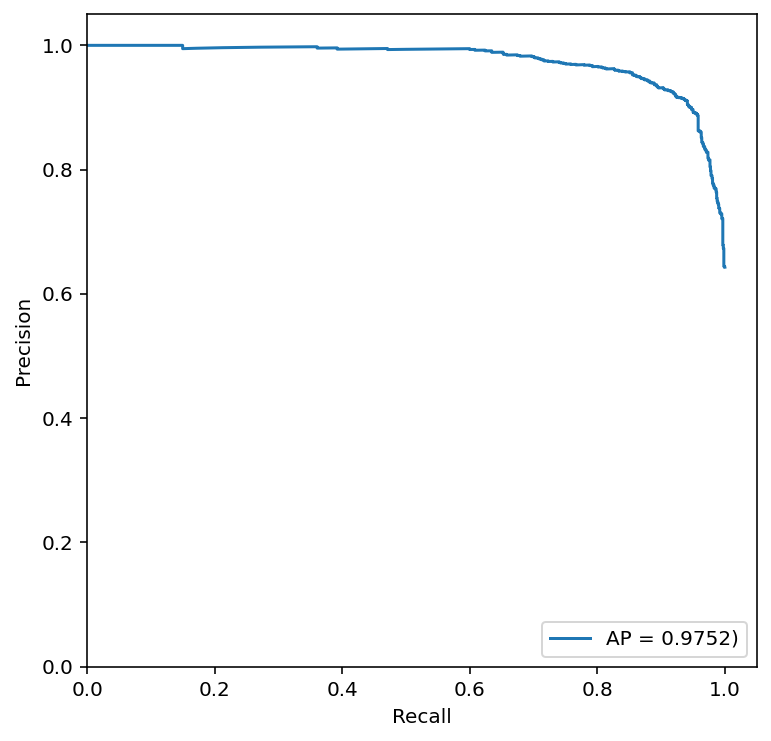

In [27]:
prec, rcl, thres = precision_recall_curve(df_rank.y_test, df_rank.scores)
ap = average_precision_score(df_rank.y_test, df_rank.scores)
plt.figure(figsize=(6,6))
plt.plot(rcl, prec, label='AP = %0.4f)' % ap)
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc="lower right")

###  precision_recall 테이블
- 주어진 샘플을 점수순을 소팅하여 정밀도, 리콜, 경계치 세가지 값을 리턴한다
- P-R 테이블 보기 (리콜이 1인 곳의 값부터 보여준다: 위 P-R 그래프의 우하단부터)
- 검증 데이터 2500개 중에 1922개의 샘플까지만 테이블에 들어있다
- 리콜이 1에 도달한 이후는 더 그릴 필요가 없음

In [28]:
# 정밀도, 리콜 테이블
PR = pd.DataFrame({"precision":prec[::-1], "recall":rcl[::-1]})
PR

,precision,recall
0,1.000000,0.000000
1,1.000000,0.000805
2,1.000000,0.001610
3,1.000000,0.002415
4,1.000000,0.003221
...,...,...
1928,0.643672,0.999195
1929,0.643339,0.999195
1930,0.643005,0.999195
1931,0.642672,0.999195


<AxesSubplot:>

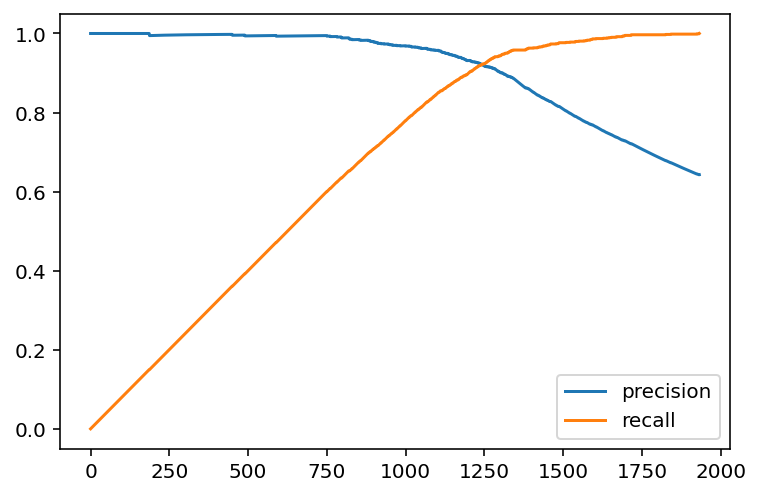

In [29]:
# P-R 테이블 내용을 그래프로 보기
PR.plot()

In [30]:
# PR 테이블의 첫 행은 삭제 (threshold와 행 갯수를 맞추기 위해서)
PR = PR[1:].reset_index(drop=True)
PR

,precision,recall
0,1.000000,0.000805
1,1.000000,0.001610
2,1.000000,0.002415
3,1.000000,0.003221
4,1.000000,0.004026
...,...,...
1927,0.643672,0.999195
1928,0.643339,0.999195
1929,0.643005,0.999195
1930,0.642672,0.999195


In [31]:
# treshold 컬럼 추가
# 경계값을 임의의 등간격으로 사용하지 않고, 주어진 샘플의 점수들을 사용한다
# 점수를 높은순으로 바꾸기 위해서 [::-1] 사용
PR["thres"] = thres[::-1]
PR

,precision,recall,thres
0,1.000000,0.000805,7.944164
1,1.000000,0.001610,7.122804
2,1.000000,0.002415,6.996672
3,1.000000,0.003221,6.816370
4,1.000000,0.004026,6.770477
...,...,...,...
1927,0.643672,0.999195,-3.222318
1928,0.643339,0.999195,-3.223941
1929,0.643005,0.999195,-3.232311
1930,0.642672,0.999195,-3.234762


## 최소한의 리콜값 조건을 우선 선택하는 경우

In [32]:
PR[1690:1700]

,precision,recall,thres
1690,0.729746,0.993559,-2.281656
1691,0.729314,0.993559,-2.286488
1692,0.728884,0.993559,-2.287570
1693,0.728453,0.993559,-2.297949
1694,0.728614,0.994364,-2.299024
1695,0.728774,0.995169,-2.299894
1696,0.728344,0.995169,-2.300763
1697,0.727915,0.995169,-2.313178
1698,0.727487,0.995169,-2.323929
1699,0.727059,0.995169,-2.324577


In [33]:
# PR 테이블을 위에서부터 검색하여 처음으로 리콜값을 만족하는 지점을 argmax로 찾는다
# False 에서 처음으로 True가 되는 지점
recall_min = 0.99 # 원하는 리콜 최소값
thres_cut = np.argmax(PR.recall >= recall_min) # 조건을 만족하는 첫번째 위치
print(thres_cut)

1652


In [34]:
print("해당 지점의 리콜", PR.recall[thres_cut])
print("경계치 (threshold):", PR.thres[thres_cut])

해당 지점의 리콜 0.9903381642512077
경계치 (threshold): -2.066736975378456


In [35]:
# 새로운 분류 경계치 thres_cut를 사용한 분류 결과
new_y_pred = df_rank["scores"] >= PR.thres[thres_cut]

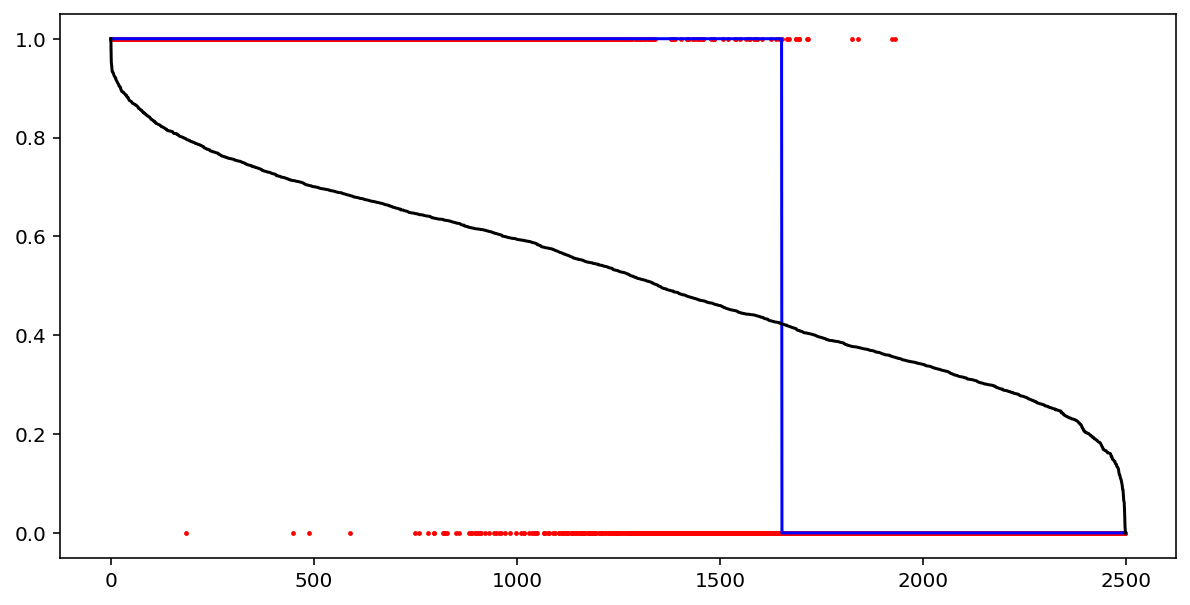

In [36]:
# 새로운 예측치 new_y_pred를 사용하여 예측값, 실제값, 분류 경계치 그리기
plt.figure(figsize=(10,5))
plt.scatter(range(len(y_test)), df_rank.y_test.values, c='r', s=2)
plt.plot(new_y_pred.values, c='b')
plt.plot(df_rank.scores_sc.values, c='k')

In [37]:
show_clf_result(df_rank.y_test, new_y_pred)

[[ 835  423]
 [  12 1230]]
              precision    recall  f1-score   support

           0       0.99      0.66      0.79      1258
           1       0.74      0.99      0.85      1242

    accuracy                           0.83      2500
   macro avg       0.86      0.83      0.82      2500
weighted avg       0.87      0.83      0.82      2500



## (연습) 최소한의 리콜을 0.995로 정했을 때의 모델을 만들고 성능을 비교하시오

In [38]:
# (풀이)



## 최소한의 정밀도를 우선 선택하는 경우

In [39]:
prec_min = 0.97
thres_cut = np.argmax(PR.precision < prec_min)
print(thres_cut)

960


In [40]:
print("해당 지점의 정밀도", PR.precision[thres_cut])
print("경계치 threshold (이상):", PR.thres[thres_cut])

해당 지점의 정밀도 0.9698231009365245
경계치 threshold (이상): 1.060558501172422


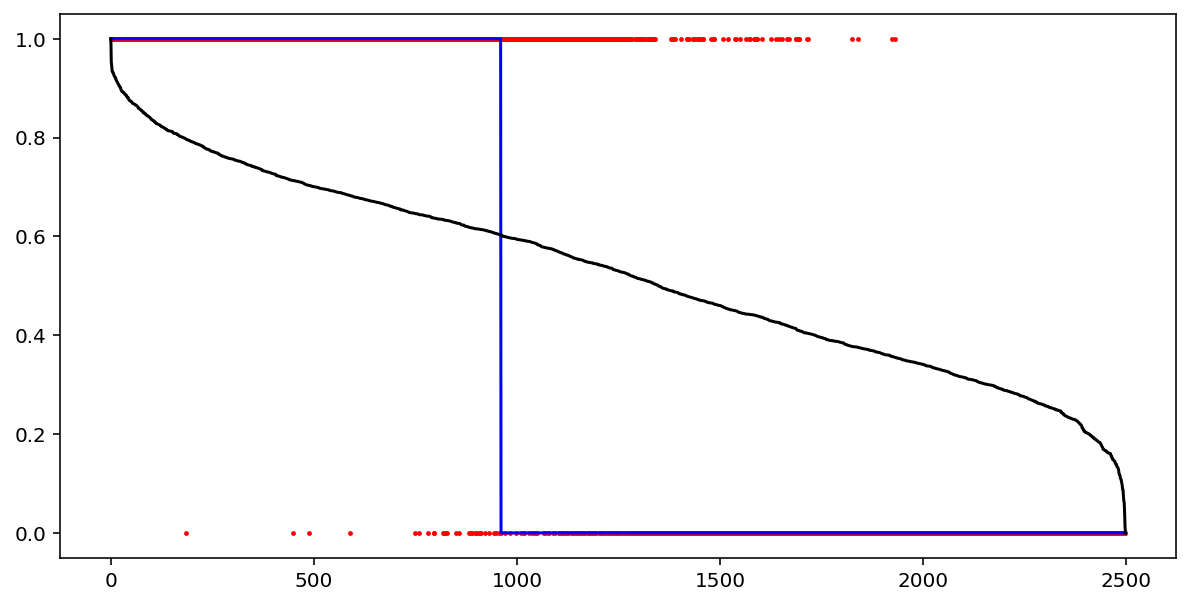

In [41]:
# 새로운 예측치 new_y_pred를 사용하여 예측값, 실제값, 분류 경계치 그리기
new_y_pred = df_rank["scores"] >= PR.thres[thres_cut]

plt.figure(figsize=(10,5))
plt.scatter(range(len(y_test)), df_rank.y_test.values, c='r', s=2)
plt.plot(new_y_pred.values, c='b')
plt.plot(df_rank.scores_sc.values, c='k')

In [42]:
show_clf_result(df_rank.y_test, new_y_pred)

[[1229   29]
 [ 310  932]]
              precision    recall  f1-score   support

           0       0.80      0.98      0.88      1258
           1       0.97      0.75      0.85      1242

    accuracy                           0.86      2500
   macro avg       0.88      0.86      0.86      2500
weighted avg       0.88      0.86      0.86      2500



## (연습) 최소한의 정밀도를 0.99로 정했을 때의 모델을 만들고 성능을 비교하시오

In [43]:
# (풀이)



# 정답

## (연습) 점수순을 소팅한 결과 실제 값이 다음과 같을 때 ROC 를 그리시오
- 실제 값: [1,0,1,1,0,1,0,1,0,0]

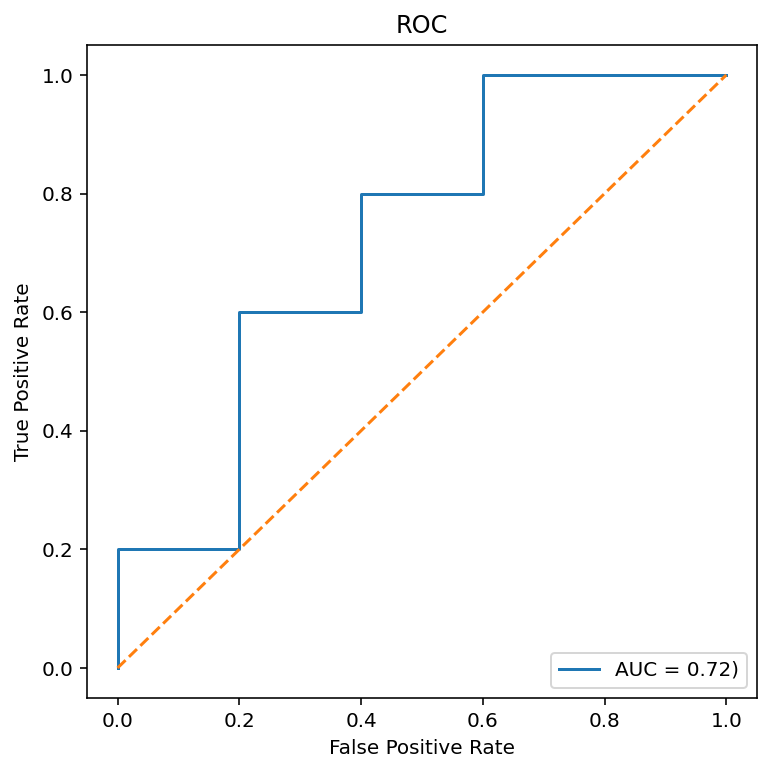

In [44]:
new_y_test = [1,0,1,1,0,1,0,1,0,0]
fpr, tpr, _ = roc_curve(new_y_test, scores_10)

roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label='AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")

## (연습) 위의 3명중 의사를 완벽한 의사와, 랜덤 예측 이하의 의사를 만들어 보시오

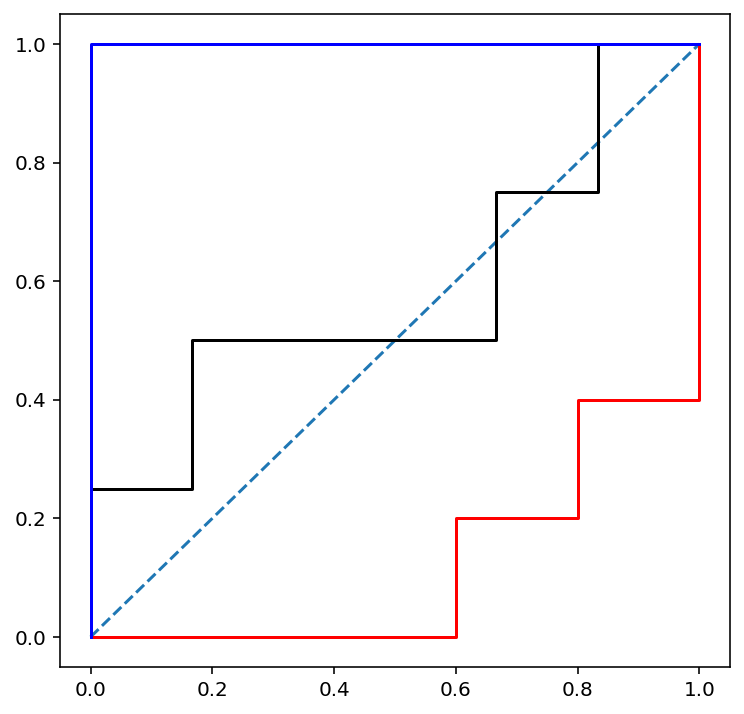

In [45]:
y_test_sample = [[0,0,0,1,0,1,0,1,1,1],
         [1,0,1,0,0,0,1,0,1,0],
         [1,1,1,1,1,0,0,0,0,0]]

plt.figure(figsize=(6,6))    
plt.plot([0, 1], [0, 1], linestyle='--')

my_color = ['r', 'k', 'b']
for i in range(len(y_test_sample)):
    fpr, tpr, _ = roc_curve(y_test_sample[i], scores_10)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, c=my_color[i])

## (연습) 최소한의 리콜을 0.995로 정했을 때의 모델을 만들고 성능을 비교하시오

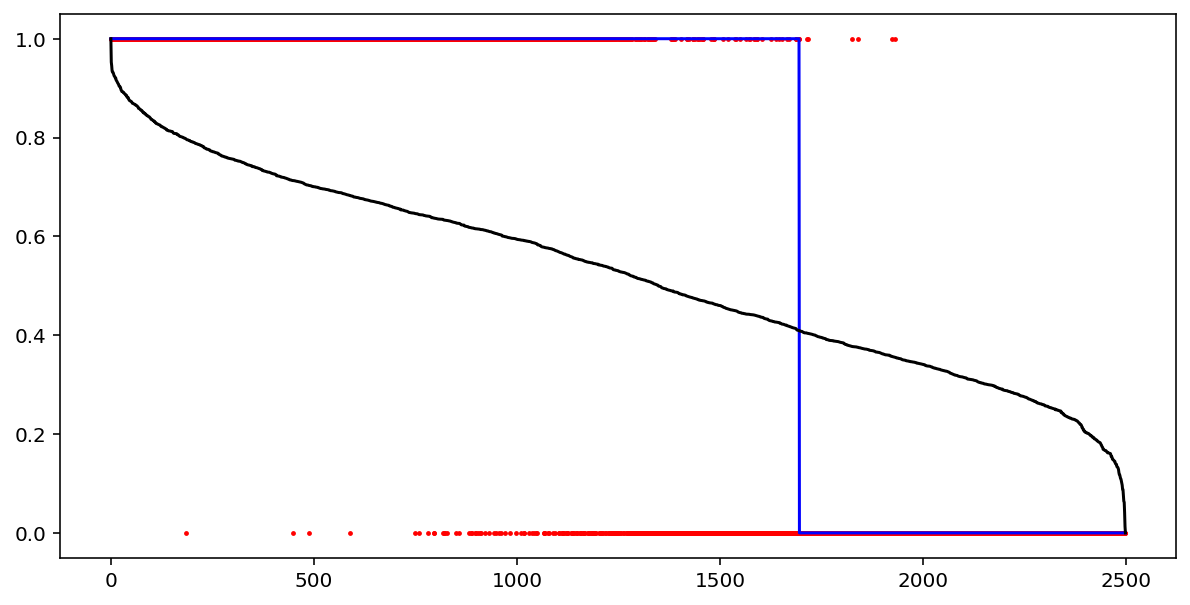

In [46]:
recall_min = 0.995
thres_cut = np.argmax(PR.recall >= recall_min) # 조건을 만족하는 첫번째 위치
new_y_pred = df_rank["scores"] >= PR.thres[thres_cut]

plt.figure(figsize=(10,5))
plt.scatter(range(len(y_test)), df_rank.y_test.values, c='r', s=2)
plt.plot(new_y_pred.values, c='b')
plt.plot(df_rank.scores_sc.values, c='k')

In [47]:
show_clf_result(df_rank.y_test, new_y_pred)

[[ 798  460]
 [   6 1236]]
              precision    recall  f1-score   support

           0       0.99      0.63      0.77      1258
           1       0.73      1.00      0.84      1242

    accuracy                           0.81      2500
   macro avg       0.86      0.81      0.81      2500
weighted avg       0.86      0.81      0.81      2500



## (연습) 최소한의 정밀도를 0.99로 정했을 때의 모델을 만들고 성능을 비교하시오

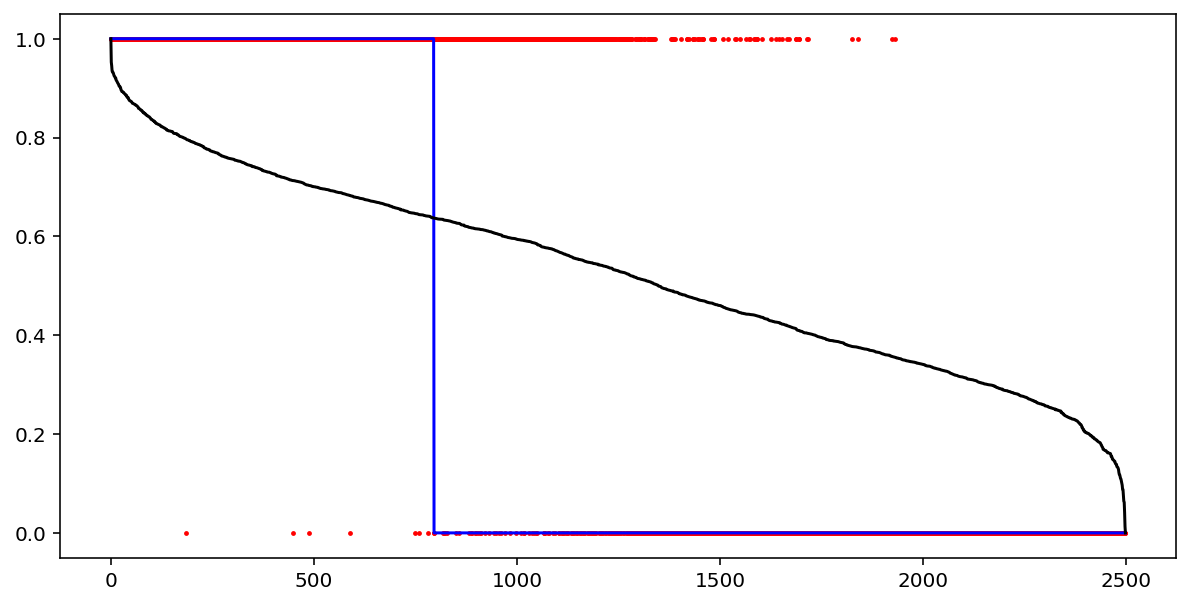

In [48]:
prec_min = 0.99
thres_cut = np.argmax(PR.precision < prec_min)
new_y_pred = df_rank["scores"] >= PR.thres[thres_cut]

plt.figure(figsize=(10,5))
plt.scatter(range(len(y_test)), df_rank.y_test.values, c='r', s=2)
plt.plot(new_y_pred.values, c='b')
plt.plot(df_rank.scores_sc.values, c='k')

In [49]:
show_clf_result(df_rank.y_test, new_y_pred)

[[1250    8]
 [ 454  788]]
              precision    recall  f1-score   support

           0       0.73      0.99      0.84      1258
           1       0.99      0.63      0.77      1242

    accuracy                           0.82      2500
   macro avg       0.86      0.81      0.81      2500
weighted avg       0.86      0.82      0.81      2500

